In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import datetime
from scipy import interpolate
import numpy as np
import scipy.stats as st
import matplotlib.patches as mpatches

# get traffic data for years 2017 - 2020
datafiles = {'2017': "../Resources/2017_traffic_atr_volume.csv",
            '2018': "../Resources/2018_traffic_atr_volume.csv",
            '2019': "../Resources/2019_traffic_atr_volume.csv",
            '2020': "../Resources/2020_traffic_atr_volume.csv"}

# loop to create a dataframe for each year
traffic = {}
for i in datafiles:
    traffic[i] = pd.DataFrame()
    traffic[i] = pd.read_csv(datafiles[i])
    traffic[i] = traffic[i].rename(columns={"station_id": "Station ID", 'dir_of_travel': 'Direction of Travel', 'lane_of_travel': 'Lane of Travel', 'date': 'Date'})

traffic['2020'].head()
print(len(traffic['2017']))
print(len(traffic['2018']))
print(len(traffic['2019']))
print(len(traffic['2020']))

47850
45496
64466
45779


In [2]:
# tally up daily totals for each
condensed = {}
for i in traffic:
    condensed[i] = pd.DataFrame({'Station ID': traffic[i]['Station ID'], 'Date': traffic[i]['Date']})
    condensed[i]['Daily Traffic Volume'] = traffic[i].iloc[:, 4:28].sum(axis=1)

condensed['2020'].head()

,Station ID,Date,Daily Traffic Volume
0,26,2020-01-01,5335
1,26,2020-01-01,1634
2,26,2020-01-01,5953
3,26,2020-01-01,2257
4,26,2020-01-02,6434


In [3]:
# add up all stations for each day
daily_traffic = {}
for i in condensed:
    daily_traffic[i] = pd.DataFrame()
    daily_total = condensed[i].groupby('Date').sum()['Daily Traffic Volume']
    daily_traffic[i] = pd.DataFrame({"Daily Traffic Volume": daily_total})

# 2017-2020 into one dataframe
traf1718 = pd.concat([daily_traffic['2017'], daily_traffic['2018']], axis=0)
traf1920 = pd.concat([daily_traffic['2019'], daily_traffic['2020']], axis=0)
daily_traffic['All'] = pd.concat([traf1718, traf1920], axis=0)

daily_traffic['2019'].head()

,Daily Traffic Volume
Date,
2019-01-01,547690
2019-01-02,835654
2019-01-03,877877
2019-01-04,972684
2019-01-05,774054


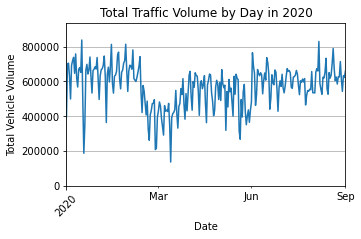

In [4]:

# Select year for graph, or 'All' for every year
year_select = '2020'

x = daily_traffic[year_select].index
y = daily_traffic[year_select]['Daily Traffic Volume']

# graph date ticks
plt.figure(figsize=(5,3))
ax = plt.gca()
x = [datetime.strptime(date, "%Y-%m-%d") for date in x]
plt.plot(x, y)
ax.set_xlim([x[0], x[-1]])

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(3,6,9), bymonthday=-1))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

# graph formatting
plt.title(f'Total Traffic Volume by Day in {year_select}')
ax.grid(axis='both')
plt.ylim(0,y.max()+100000)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Total Vehicle Volume')

plt.savefig('../Images/Traffic-AllYears.jpg')
plt.show()

In [5]:
aqi_filepath = '../Resources/Combined_AQI.csv'

aqi_data = pd.DataFrame()
aqi_data = pd.read_csv(aqi_filepath)
aqi_data = aqi_data.rename(columns={'Daily Mean PM2.5 Concentration': 'PM2.5'})
dates = aqi_data['Date']
#dates = [datetime.strptime(d, "%m/%d/%Y") for d in dates]
aqi_data['Date'] = pd.to_datetime(aqi_data.Date)
aqi_data['Date'] = aqi_data['Date'].dt.strftime("%Y-%m-%d")

aqi_traffic = pd.merge(daily_traffic['2020'], aqi_data, how='inner', on='Date')

#aqi_data.head()
aqi_traffic.head()

,Date,Daily Traffic Volume,Source_x,Site ID_x,POC_x,PM2.5,UNITS_x,DAILY_AQI_VALUE_x,Site Name_x,DAILY_OBS_COUNT_x,...,Unnamed: 34_y,Unnamed: 35_y,Unnamed: 36_y,Unnamed: 37_y,Unnamed: 38_y,Unnamed: 39_y,day_y,month_y,year_y,unix_y
0,2020-01-01,396330,AQS,270530962,3,9.6,ug/m3 LC,40,Near Road I-35/I-94,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-02,698650,AQS,270530962,3,7.5,ug/m3 LC,31,Near Road I-35/I-94,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-03,704508,AQS,270530962,3,9.5,ug/m3 LC,40,Near Road I-35/I-94,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-04,627165,AQS,270530962,3,7.5,ug/m3 LC,31,Near Road I-35/I-94,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-05,498698,AQS,270530962,3,6.9,ug/m3 LC,29,Near Road I-35/I-94,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


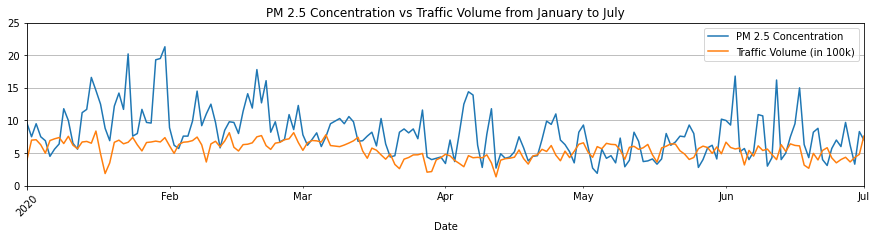

In [6]:
x = aqi_traffic['Date']
y = aqi_traffic['PM2.5']
y2 = aqi_traffic['Daily Traffic Volume']

# graph date ticks
plt.figure(figsize=(15,3))
ax = plt.gca()
dates = x
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
plt.plot(dates, y, label='PM 2.5 Concentration')
plt.plot(dates, (y2/100000), label='Traffic Volume (in 100k)')
ax.set_xlim([dates[0], dates[-1]])

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

# graph formatting
plt.title(f'PM 2.5 Concentration vs Traffic Volume from January to July')
ax.grid(axis='both')
plt.xlim(pd.Timestamp('2020-1-1'), pd.Timestamp('2020-7-1'))
plt.ylim(0,25)
plt.xticks(rotation=45)
plt.xlabel('Date')
ax.legend()

plt.savefig('../Images/AQI-v-Traffic-2020.jpg')
plt.show()

The r-squared is: 0.007675585010274515


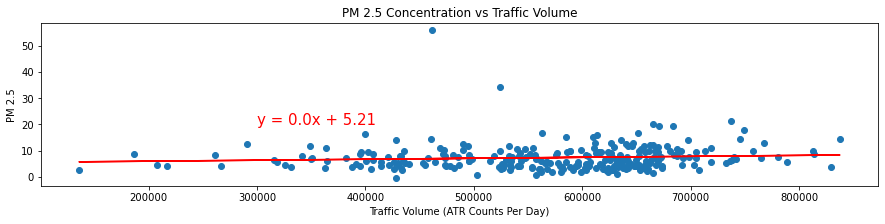

In [7]:
x = aqi_traffic['Daily Traffic Volume']
y = aqi_traffic['PM2.5']

# regession
slope, intercept, r, p, stderr = st.linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# plot graph
plt.figure(figsize=(15,3))
plt.plot(x,regress_values,"r-")
plt.scatter(x,y)
plt.annotate(line_eq,(300000,20),fontsize=15,color="red")
plt.title('PM 2.5 Concentration vs Traffic Volume')
plt.xlabel('Traffic Volume (ATR Counts Per Day)')
plt.ylabel('PM 2.5')
plt.savefig('../Images/AQI-v-Traffic-Correlation.jpg')
print(f"The r-squared is: {r**2}")
plt.show()